# Prep

## Library

In [125]:
from ds_common_utils.aux.io.snowflake_tools import SnowflakeTools
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.lines as mlines

## Connection

In [2]:
con = SnowflakeTools(
    role="INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD",
    warehouse="INSIGHT_ANALYST_WH",
    database="BDWPRD_DE",
    schema="IA_MERCH_DE"
)

## Item list

In [22]:
# Load both AU and NZ sheets from the Excel file
item_list = pd.read_excel("Item list.xlsx", sheet_name=None)

# Replace sheet names if needed
au_items = item_list['AU']
nz_items = item_list['NZ']

# Standardise column names (optional but helpful)
au_items.columns = au_items.columns.str.strip().str.lower()
nz_items.columns = nz_items.columns.str.strip().str.lower()

# Ensure item_number is string with leading zeroes
au_items['item_number'] = au_items['item_number'].astype(str).str.zfill(7)
nz_items['item_number'] = nz_items['item_number'].astype(str).str.zfill(7)

Index(['item_number', 'item_description'], dtype='object')
Index(['item_number', 'item_description'], dtype='object')


In [24]:
# Read product hierarchy
product_hierarchy = con.read_sql_file_into_pandas(
    file="sql/item-hierarchy.sql"
)

In [25]:
# Clean column names
product_hierarchy.columns = (
    product_hierarchy.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

# Ensure item_number is string with 7-digit padding
product_hierarchy['item_number'] = product_hierarchy['item_number'].astype(str).str.zfill(7)

In [26]:
# Merge enriched hierarchy into AU and NZ item lists
au_items_enriched = au_items.merge(product_hierarchy, on='item_number', how='left')
nz_items_enriched = nz_items.merge(product_hierarchy, on='item_number', how='left')


In [29]:
# Function to print unique values for each hierarchy column
def show_unique_hierarchy(df, label):
    print(f"\n🔹 {label}: Unique item_category_name")
    print(df['item_category_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_department_name")
    print(df['item_department_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_sub_department_name")
    print(df['item_sub_department_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_class_name")
    print(df['item_class_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_sub_class_name")
    print(df['item_sub_class_name'].dropna().unique())

# Show for both AU and NZ
show_unique_hierarchy(au_items_enriched, "AU ITEMS")
show_unique_hierarchy(nz_items_enriched, "NZ ITEMS")



🔹 AU ITEMS: Unique item_category_name
['200 TIMBER']

🔹 AU ITEMS: Unique item_department_name
['300 INDOOR TIMBER AND BOARDS']

🔹 AU ITEMS: Unique item_sub_department_name
['400 PANELS']

🔹 AU ITEMS: Unique item_class_name
['500 PANELS' '500 PANELS BULK STACK']

🔹 AU ITEMS: Unique item_sub_class_name
['600 EXOTIC PANELS' '600 PANELS BULK STACK' '600 PANELS'
 '600 DRESSED PINE PNL BULK STCK']

🔹 NZ ITEMS: Unique item_category_name
['200 TIMBER']

🔹 NZ ITEMS: Unique item_department_name
['300 INDOOR TIMBER AND BOARDS']

🔹 NZ ITEMS: Unique item_sub_department_name
['400 PANELS']

🔹 NZ ITEMS: Unique item_class_name
['500 PANELS' '500 PANELS BULK STACK']

🔹 NZ ITEMS: Unique item_sub_class_name
['600 EXOTIC PANELS' '600 PANELS' '600 PANELS BULK STACK'
 '600 DRESSED PINE PNL BULK STCK']


# Class-based Performance

In [150]:
start_date = "'2024-07-31'"
end_date = "'2025-06-11'"
start_rrp_date = "2025-01-27"

start_date_LY = "'2023-07-31'"
end_date_LY = "'2024-06-11'"
start_rrp_date_LY = "2024-01-27"

## AU

In [74]:
country = "'AU'"

In [96]:
df_class_transactions = con.read_sql_file_into_pandas(
    file="sql/class-transactions.sql",
    formatting={
        'start_date': start_date,
        'end_date': end_date,
        'country': country
    }
)

print(df_class_transactions.head())

  WEEK_START ITEM_NUMBER                            ITEM_DESCRIPTION  \
0 2024-07-29     0215400  TAS OAK FEATURE GRADE PANEL++1800X600X19MM   

  ITEM_CLASS_NAME ITEM_SUB_CLASS_NAME  TOTAL_SALES  TOTAL_QUANTITY  \
0      500 PANELS          600 PANELS      2954.51            25.0   

   UNIQUE_CUSTOMERS  
0                21  


In [111]:
df_class_transactions_LY = con.read_sql_file_into_pandas(
    file="sql/class-transactions.sql",
    formatting={
        'start_date': start_date_LY,
        'end_date': end_date_LY,
        'country': country
    }
)

print(df_class_transactions_LY.head())

  WEEK_START ITEM_NUMBER                                   ITEM_DESCRIPTION  \
0 2023-07-31     0019144          PINE FJ LAM UTILITY PANEL++1200X405X18MM^   
1 2023-07-31     0019145          PINE FJ LAM UTILITY PANEL++1200X300X18MM^   
2 2023-07-31     0019146          PINE FJ LAM UTILITY PANEL++1200X600X18MM^   
3 2023-07-31     0019147          PINE FJ LAM UTILITY PANEL++1800X405X18MM^   
4 2023-07-31     0123329  TAS OAK SELECT GRADE PANEL++1200X405X17MM TIMB...   

  ITEM_CLASS_NAME ITEM_SUB_CLASS_NAME  TOTAL_SALES  TOTAL_QUANTITY  \
0      500 PANELS          600 PANELS        90.00             5.0   
1      500 PANELS          600 PANELS       645.80            36.0   
2      500 PANELS          600 PANELS       338.18            12.0   
3      500 PANELS          600 PANELS        98.18             2.0   
4      500 PANELS          600 PANELS       261.81             9.0   

   UNIQUE_CUSTOMERS  
0                 2  
1                19  
2                 8  
3               

In [151]:
# Clean and prep function with cutoff_date passed separately
def prepare_df(df, au_items_enriched, cutoff_date, label):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    df['item_number'] = df['item_number'].astype(str).str.zfill(7)
    df['week_start'] = pd.to_datetime(df['week_start'])
    df['rrp_increase'] = df['item_number'].isin(au_items_enriched['item_number']).map({True: 'Yes', False: 'No'})
    df['period'] = df['week_start'].apply(lambda x: 'Pre' if x < pd.to_datetime(cutoff_date) else 'Post')
    df['year_label'] = label
    return df

# Apply with correct cutoff for each
df_class_transactions = prepare_df(df_class_transactions, au_items_enriched, start_rrp_date, 'This Year')
df_class_transactions_LY = prepare_df(df_class_transactions_LY, au_items_enriched, start_rrp_date_LY, 'Last Year')

# Combine datasets
df_all = pd.concat([df_class_transactions, df_class_transactions_LY], ignore_index=True)

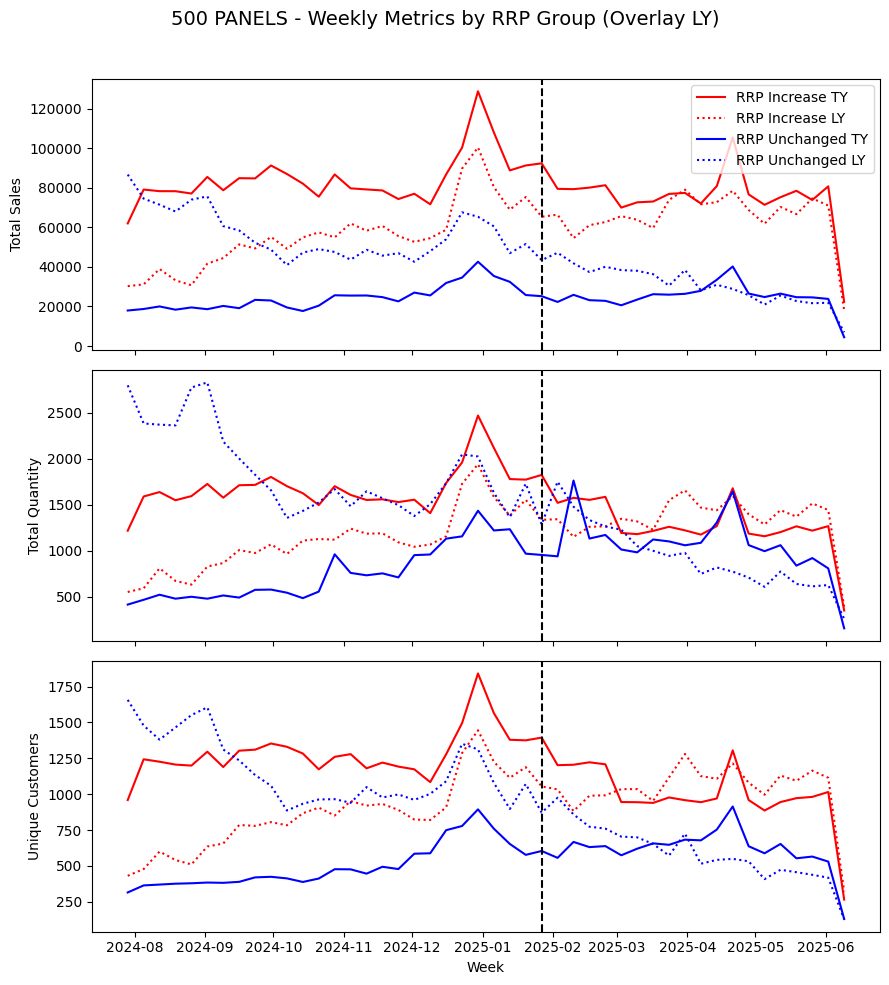

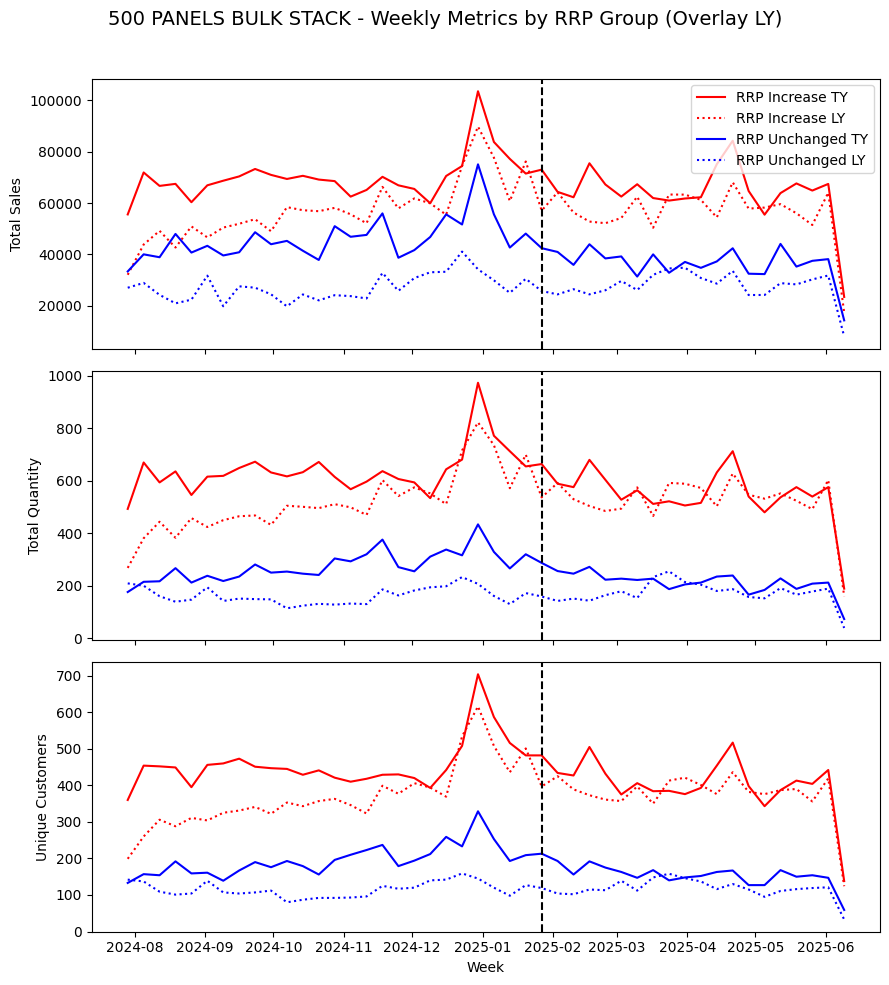

,item_class_name,rrp_increase,period,year_label,total_sales,total_quantity,unique_customers
0,500 PANELS,Yes,Pre,This Year,4022.98,79.98,61.15
1,500 PANELS,Yes,Pre,Last Year,2970.44,58.72,45.63
2,500 PANELS,Yes,Post,This Year,3619.53,61.64,48.18
3,500 PANELS,Yes,Post,Last Year,3234.93,66.30,51.27
4,500 PANELS,No,Pre,This Year,945.09,29.09,19.27
5,500 PANELS,No,Pre,Last Year,980.16,32.35,20.14
6,500 PANELS,No,Post,This Year,956.15,40.44,23.52
7,500 PANELS,No,Post,Last Year,928.91,28.04,17.90
8,500 PANELS BULK STACK,Yes,Pre,This Year,10004.89,91.43,65.23
9,500 PANELS BULK STACK,Yes,Pre,Last Year,8177.61,74.09,52.81


In [152]:
formatted_class_summaries = []

for class_name in df_all['item_class_name'].unique():
    df_class = df_all[df_all['item_class_name'] == class_name]
    df_weekly = df_class.groupby(
        ['week_start', 'rrp_increase', 'year_label']
    )[['total_sales', 'total_quantity', 'unique_customers']].sum().reset_index()

    df_summary = df_class.groupby(
        ['item_class_name', 'rrp_increase', 'period', 'year_label']
    )[['total_sales', 'total_quantity', 'unique_customers']].mean().reset_index().round(2)
    df_summary['rrp_order'] = df_summary['rrp_increase'].map({'Yes': 0, 'No': 1})
    df_summary['period_order'] = df_summary['period'].map({'Pre': 0, 'Post': 1})
    df_summary['year_order'] = df_summary['year_label'].map({'This Year': 0, 'Last Year': 1})
    df_summary = df_summary.sort_values(by=['item_class_name', 'rrp_order', 'period_order', 'year_order'])
    df_summary = df_summary.drop(columns=['rrp_order', 'period_order', 'year_order'])
    formatted_class_summaries.append(df_summary)

    fig, axes = plt.subplots(3, 1, figsize=(9, 10), sharex=True)
    fig.suptitle(f"{class_name} - Weekly Metrics by RRP Group (Overlay LY)", fontsize=14)

    for ax, metric in zip(axes, ['total_sales', 'total_quantity', 'unique_customers']):
        for rrp_status in ['Yes', 'No']:
            for year_label in ['This Year', 'Last Year']:
                group = df_weekly[
                    (df_weekly['rrp_increase'] == rrp_status) &
                    (df_weekly['year_label'] == year_label)
                ]
                x = group['week_start'] + pd.Timedelta(weeks=52) if year_label == 'Last Year' else group['week_start']
                ax.plot(
                    x, group[metric],
                    color=plot_colors[rrp_status],
                    linestyle=line_styles[year_label]
                )
        ax.axvline(pd.to_datetime(start_rrp_date), color='black', linestyle='--')
        ax.set_ylabel(metric.replace('_', ' ').title())

    axes[-1].set_xlabel("Week")

    # Custom legend
    legend_lines = [
        mlines.Line2D([], [], color='red', linestyle='solid', label='RRP Increase TY'),
        mlines.Line2D([], [], color='red', linestyle='dotted', label='RRP Increase LY'),
        mlines.Line2D([], [], color='blue', linestyle='solid', label='RRP Unchanged TY'),
        mlines.Line2D([], [], color='blue', linestyle='dotted', label='RRP Unchanged LY'),
    ]
    fig.legend(
        handles=legend_lines,
        loc='lower center',
        bbox_to_anchor=(0.875, 0.81),
        ncol=1,
        fontsize='medium'
    )

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Combine summary tables
final_summary_table = pd.concat(formatted_class_summaries, ignore_index=True)
final_summary_table

## Weekly trends summary

In [157]:
# Define time parameters
start_date = "'2024-07-31'"
end_date = "'2025-06-11'"
start_rrp_date = "2025-01-27"

start_date_LY = "'2023-07-31'"
end_date_LY = "'2024-06-11'"
start_rrp_date_LY = "2024-01-27"

params = {
    'AU': {
        'start_date': start_date,
        'end_date': end_date,
        'start_rrp_date': start_rrp_date,
        'start_date_LY': start_date_LY,
        'end_date_LY': end_date_LY,
        'start_rrp_date_LY': start_rrp_date_LY,
    },
    'NZ': {
        'start_date': start_date,
        'end_date': end_date,
        'start_rrp_date': start_rrp_date,
        'start_date_LY': start_date_LY,
        'end_date_LY': end_date_LY,
        'start_rrp_date_LY': start_rrp_date_LY,
    }
}

In [158]:
# Define reusable preparation function
def prepare_df(df, enriched_items, cutoff_date, year_label, country_label):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    df['item_number'] = df['item_number'].astype(str).str.zfill(7)
    df['week_start'] = pd.to_datetime(df['week_start'])
    df['rrp_increase'] = df['item_number'].isin(enriched_items['item_number']).map({True: 'Yes', False: 'No'})
    df['period'] = df['week_start'].apply(lambda x: 'Pre' if x < pd.to_datetime(cutoff_date) else 'Post')
    df['year_label'] = year_label
    df['country'] = country_label
    return df

In [174]:
# Define plot settings
plot_colors = {'Yes': 'red', 'No': 'blue'}
line_styles = {'This Year': 'solid', 'Last Year': 'dotted'}

# Storage
df_all_combined = []
formatted_class_summaries = []
yoy_summary_rows = []

# Loop through each country
def run_country_analysis():
    for country, cfg in params.items():
        df_ty = con.read_sql_file_into_pandas(
            file="sql/class-transactions.sql",
            formatting={
                'start_date': cfg['start_date'],
                'end_date': cfg['end_date'],
                'country': f"'{country}'"
            }
        )
        df_ly = con.read_sql_file_into_pandas(
            file="sql/class-transactions.sql",
            formatting={
                'start_date': cfg['start_date_LY'],
                'end_date': cfg['end_date_LY'],
                'country': f"'{country}'"
            }
        )

        enriched_items = au_items_enriched if country == 'AU' else nz_items_enriched

        df_ty = prepare_df(df_ty, enriched_items, cfg['start_rrp_date'], 'This Year', country)
        df_ly = prepare_df(df_ly, enriched_items, cfg['start_rrp_date_LY'], 'Last Year', country)

        df_country = pd.concat([df_ty, df_ly], ignore_index=True)
        df_all_combined.append(df_country)

        for class_name in df_country['item_class_name'].unique():
            df_class = df_country[df_country['item_class_name'] == class_name]
            df_weekly = df_class.groupby(
                ['week_start', 'rrp_increase', 'year_label']
            )[['total_sales', 'total_quantity', 'unique_customers']].sum().reset_index()

            df_summary = df_class.groupby(
                ['item_class_name', 'item_sub_class_name', 'rrp_increase', 'period', 'year_label']
            )[['total_sales', 'total_quantity', 'unique_customers']].mean().reset_index().round(2)
            df_summary['country'] = country
            formatted_class_summaries.append(df_summary)

            # Compute raw sums for YOY comparison
            df_yoy_raw = df_class.groupby(
                ['item_class_name', 'rrp_increase', 'year_label']
            )[['total_sales', 'total_quantity', 'unique_customers']].sum().reset_index()
            df_yoy_pivot = df_yoy_raw.pivot_table(
                index=['item_class_name', 'rrp_increase'],
                columns='year_label',
                values=['total_sales', 'total_quantity', 'unique_customers']
            )
            df_yoy_pivot.columns = ['_'.join(col).strip() for col in df_yoy_pivot.columns.values]
            df_yoy_pivot = df_yoy_pivot.reset_index()
            df_yoy_pivot['sales_yoy'] = df_yoy_pivot['total_sales_This Year'] / df_yoy_pivot['total_sales_Last Year']
            df_yoy_pivot['quantity_yoy'] = df_yoy_pivot['total_quantity_This Year'] / df_yoy_pivot['total_quantity_Last Year']
            df_yoy_pivot['customers_yoy'] = df_yoy_pivot['unique_customers_This Year'] / df_yoy_pivot['unique_customers_Last Year']
            df_yoy_pivot['country'] = country
            yoy_summary_rows.append(df_yoy_pivot)

            # Plot
            fig, axes = plt.subplots(3, 1, figsize=(9, 10), sharex=True)
            fig.suptitle(f"{class_name} - {country} - Weekly Metrics by RRP Group", fontsize=14)

            for ax, metric in zip(axes, ['total_sales', 'total_quantity', 'unique_customers']):
                for rrp_status in ['Yes', 'No']:
                    for year_label in ['This Year', 'Last Year']:
                        group = df_weekly[
                            (df_weekly['rrp_increase'] == rrp_status) &
                            (df_weekly['year_label'] == year_label)
                        ]
                        x = group['week_start'] + pd.Timedelta(weeks=52) if year_label == 'Last Year' else group['week_start']
                        ax.plot(
                            x, group[metric],
                            color=plot_colors[rrp_status],
                            linestyle=line_styles[year_label]
                        )
                ax.axvline(pd.to_datetime(cfg['start_rrp_date']), color='black', linestyle='--')
                ax.set_ylabel(metric.replace('_', ' ').title())

            axes[-1].set_xlabel("Week")
            fig.legend(
                handles=[
                    mlines.Line2D([], [], color='red', linestyle='solid', label='RRP Increase TY'),
                    mlines.Line2D([], [], color='red', linestyle='dotted', label='RRP Increase LY'),
                    mlines.Line2D([], [], color='blue', linestyle='solid', label='RRP Unchanged TY'),
                    mlines.Line2D([], [], color='blue', linestyle='dotted', label='RRP Unchanged LY')
                ],
                loc='lower center', bbox_to_anchor=(0.875, 0.8), ncol=1, fontsize='medium')

            plt.tight_layout(rect=[0, 0.03, 1, 0.96])
            plt.show()

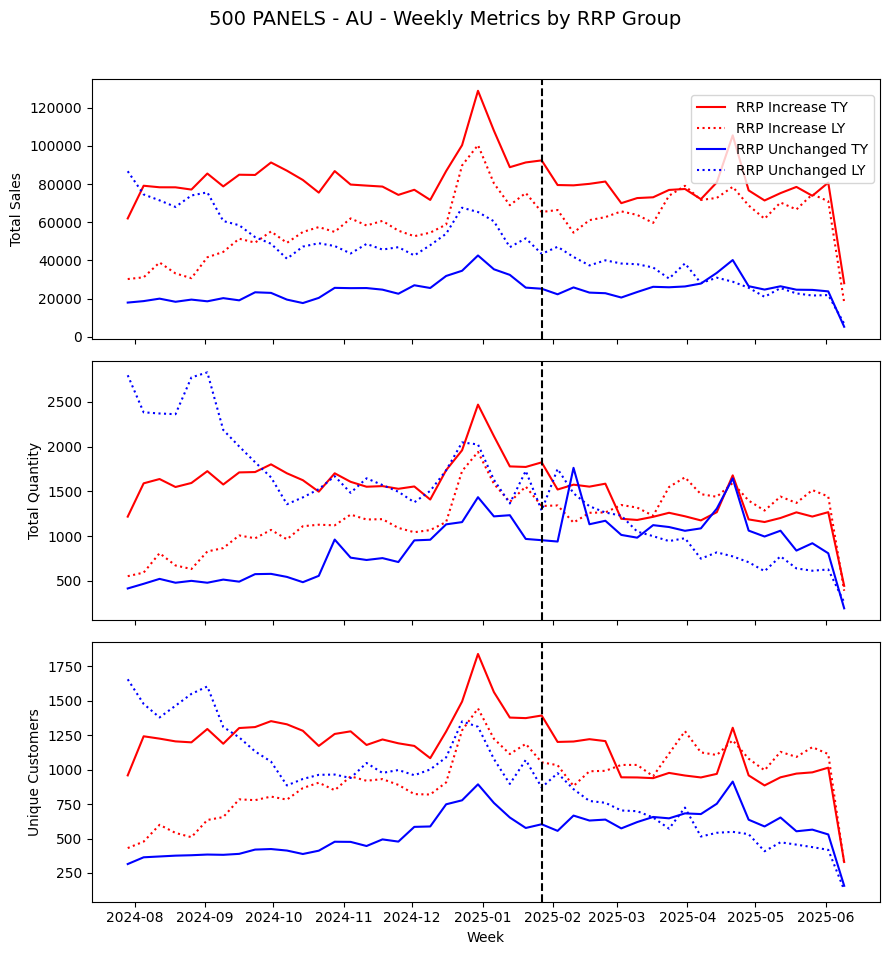

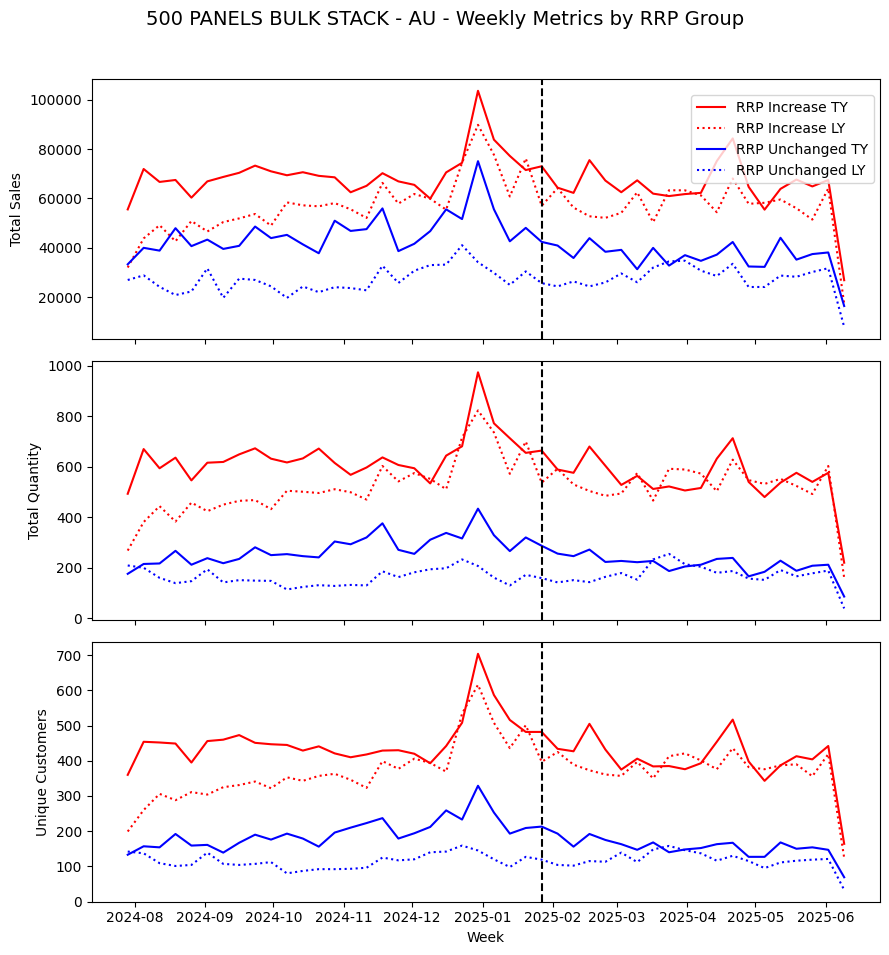

In [175]:
# Run the analysis
run_country_analysis()

In [167]:
# Combine results
df_all = pd.concat(df_all_combined, ignore_index=True)
final_summary_table = pd.concat(formatted_class_summaries, ignore_index=True)
yoy_summary_table = pd.concat(yoy_summary_rows, ignore_index=True).round(3)
yoy_summary_table

/tmp/ipykernel_961/2234606578.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(df_all_combined, ignore_index=True)


,item_class_name,rrp_increase,total_quantity_Last Year,total_quantity_This Year,total_sales_Last Year,total_sales_This Year,unique_customers_Last Year,unique_customers_This Year,sales_yoy,quantity_yoy,customers_yoy,country
0,500 PANELS,No,67629.0,40722.0,2102253.33,1136019.36,42395.0,25275.0,0.540,0.602,0.596,AU
1,500 PANELS,Yes,55263.0,69649.0,2747573.97,3722524.38,42845.0,53691.0,1.355,1.260,1.253,AU
2,500 PANELS BULK STACK,No,7660.0,11493.0,1257173.35,1929915.94,5344.0,8202.0,1.535,1.500,1.535,AU
3,500 PANELS BULK STACK,Yes,23963.0,27716.0,2612298.93,3110109.00,17142.0,19993.0,1.191,1.157,1.166,AU
